# Building car price prediction model for CarDekho website
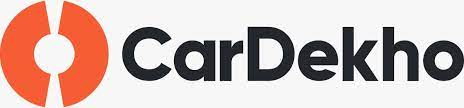
## About project
[CarDekho](https://www.cardekho.com/) is India's leading car search venture that helps users buy cars. Its website and app carry rich automotive content such as expert reviews, detailed specs and prices, comparisons as well as videos and pictures of all car brands and models available in India. The company has tie-ups with many auto manufacturers, more than 4000 car dealers and numerous financial institutions to facilitate the purchase of vehicles.

In this project, we'll collect data about used cars from CarDekho website and use it to build car price prediction model. This model may later be used by CarDekho for suggesting the price of posted by user used car.

# Importing necessary libraries for project

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
from math import ceil
import warnings

pd.options.display.max_columns = None

# Data Collection

Since we don't have access to the database of CarDekho website, there are two main ways to collect data: find existing datasets or scrape data from CarDekho website. Kaggle contains two useful for our case datasets: [Vehicle dataset](https://www.kaggle.com/nehalbirla/vehicle-dataset-from-cardekho?select=Car+details+v3.csv) (\~8000 rows) and [Used Car Prices in India](https://www.kaggle.com/saisaathvik/used-cars-dataset-from-cardekhocom?select=Cardekho_Extract.csv) (\~20000 rows). We will use this data for model building, because:
* both datasets contain similar columns which will make it easy to union them;
* in sum it is about 28000 rows, which is enough for model building;
* using existing datasets takes less time than scraping new from website;
* according to Kaggle, ~30% of used cars from [Vehicle dataset](https://www.kaggle.com/nehalbirla/vehicle-dataset-from-cardekho?select=Car+details+v3.csv) was bought in 2016-2020 and ~16% of used cars from [Used Car Prices in India](https://www.kaggle.com/saisaathvik/used-cars-dataset-from-cardekhocom?select=Cardekho_Extract.csv) was bought in 2018-2021. Therefore the data is fresh enough.

## Importing the datasets

We'll start by taking a look at first rows and shapes of datasets.

### Vehicle dataset

In [2]:
# read in the data
raw_data_1 = pd.read_csv('Car details v3.csv')

raw_data_1.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [3]:
# check the shape of dataset
raw_data_1.shape

(8128, 13)

Description of fields in Vehicle dataset:
* *name* - name of the car
* *year* - year in which car was first bought
* *selling_price* - selling price of the car
* *km_driven* - number of kilometers the car is driven
* *fuel* - fuel type of the car
* *seller_type* - tells if car is sold by individual or dealer
* *transmission* - gear transmission of the car (Automatic/Manual)
* *owner* - number of previous owners
* *mileage* - mileage of the car
* *engine* - engine capacity of the car
* *max_power* - max power of engine
* *torque* - torque of the car
* *seats* - number of seats in the car

### Used Car Prices in India dataset

In [4]:
# read in the data
raw_data_2 = pd.read_csv('Cardekho_Extract.csv')

raw_data_2.head()

,Source.Name,web-scraper-order,web-scraper-start-url,full_name,selling_price,new-price,year,seller_type,km_driven,owner_type,fuel_type,transmission_type,mileage,engine,max_power,seats
0,cardekho_extract(0-2000).csv,1611917819-1662,https://www.cardekho.com/used-car-details/used...,Maruti Alto Std,1.2 Lakh*,NaN,2012.0,Individual,"1,20,000 kms",First Owner,Petrol,Manual,Mileage19.7 kmpl,Engine796 CC,Max Power46.3 bhp,Seats5
1,cardekho_extract(0-2000).csv,1611918361-1902,https://www.cardekho.com/used-car-details/used...,Hyundai Grand i10 Asta,5.5 Lakh*,New Car (On-Road Price) : Rs.7.11-7.48 Lakh*,2016.0,Individual,"20,000 kms",First Owner,Petrol,Manual,Mileage18.9 kmpl,Engine1197 CC,Max Power82 bhp,Seats5
2,cardekho_extract(0-2000).csv,1611917012-1306,https://www.cardekho.com/used-car-details/used...,Hyundai i20 Asta,2.15 Lakh*,NaN,2010.0,Individual,"60,000 kms",First Owner,Petrol,Manual,Mileage17.0 kmpl,Engine1197 CC,Max Power80 bhp,Seats5
3,cardekho_extract(0-2000).csv,1611917695-1607,https://www.cardekho.com/used-car-details/used...,Maruti Alto K10 2010-2014 VXI,2.26 Lakh*,NaN,2012.0,Individual,"37,000 kms",First Owner,Petrol,Manual,Mileage20.92 kmpl,Engine998 CC,Max Power67.1 bhp,Seats5
4,cardekho_extract(0-2000).csv,1611914861-367,https://www.cardekho.com/used-car-details/used...,Ford Ecosport 2015-2021 1.5 TDCi Titanium BSIV,5.7 Lakh*,New Car (On-Road Price) : Rs.10.14-13.79 Lakh*,2015.0,Dealer,"30,000 kms",First Owner,Diesel,Manual,Mileage22.77 kmpl,Engine1498 CC,Max Power98.59 bhp,Seats5


In [5]:
# check the shape of dataset
raw_data_2.shape

(20026, 16)

Description of fields in Vehicle dataset:
* *Source.Name* - invalid field
* *web-scraper-order* - row id
* *web-scraper-start-url* - url of data source for current row
* *full_name* - name of the car
* *selling_price* - current selling price of used car
* *new-price* - current cost price of brand new car
* *year* - year in which car was first bought
* *seller_type* - type of seller
* *km_driven* - kilometers driven by the car
* *owner_type* - number of previous owners
* *fuel_type* - fuel type of the car
* *transmission_type* - gear transmission of the car (Automatic/Manual)
* *mileage* - mileage of the car
* *engine* - engine capacity of the car
* *max_power* - max horsepower of engine
* *seats* - number of seats in the car

## Dictionary of units in data
* **Lakh** - a unit in the Indian numbering system equal to one hundred thousand (100,000). In the Indian 2,2,3 convention of digit grouping, it is written as 1,00,000. For example, in India 150,000 rupees becomes 1.5 lakh rupees, written as ₹1,50,000 or INR 1,50,000.
* **Crore (Cr)** - a unit in the Indian numbering system equal to ten million (10,000,000) or 100 lakh in the Indian numbering system. It is written as 1,00,00,000 with the local 2,2,3 style of digit group separators.
* **kmpl** - Kilometers Per Litre is a term use to express the fuel efficiency of a vehicle. Fuel efficiency is defined as the ratio of distance travelled per unit of fuel consumed.
* **СС** - The term “cc” stands for Cubic Centimeters or simply cm³ which is a metric unit to measure the Engine's Capacity or its volume. Usually increase power of car.
* **bhp** - Traditionally ‘brake horsepower’ (bhp) has been used as the definitive measurement of engine power. It’s distinct from horsepower because it takes into account power loss due to friction – it’s measured by running an engine up to full revs, then letting it naturally slow down to a dead stop.
* **nm at rpm** - Torque is rotational force, and since an engine relies on a rotating crank to do its work, torque is the force the engine is able to generate. Modern engines generate different levels of torque at different engine speeds (RPMs, or revolutions per minute that the engine is turning through). It’s expressed in Newton-Metres (Nm), and this is what you actually feel when you’re pushed back into your seat on acceleration. A car brochure will indicate the maximum torque the engine is able to generate, and the specific RPM at which it is generated. For instance, the Maruti Dzire generates 113Nm at 4200RPM (petrol) and 190Nm at 2000RPM (diesel). This means the petrol engine produces less torque at a much higher engine speed than the diesel motor, which produces more at a quite low engine speed. The bottom line: Look for a good torque (over 110Nm) with a low RPM (4,000 or so). 1 kgm = 9.80665 Nm

# Data Cleaning

## Plan

We will do data cleaning of both datasets by following next steps:
1. Find corresponding and non-corresponding columns of both datasets.
2. For both datasets separetly:
    * Transform  non-null values of corresponding columns to unified format;
    * Decide if to leave or drop non-corresponding columns.
3. Combine datasets.
4. Manage duplicate rows, outliers and null values.

## Find corresponding and non-corresponding columns of both datasets
First of all, let's compare lists of datasets columns.

In [6]:
# for printing list in bullet list style
def bullet_list(lst, header='', sort=True, counter=True):
    if header!='' or counter:
        print(f'{header} ({len(lst)}):')
    if sort:
        lst = sorted(lst)
    for el in lst:
        print('   >', el)

# for finding intersections and differences between lists of columns
def compare_cols(data_1, data_2, return_flg=False):
    set_1, set_2 = set(data_1.columns), set(data_2.columns)
    inter, diff1, diff2 = set_1.intersection(set_2), set_1.difference(set_2), set_2.difference(set_1)
    bullet_list(inter, 'Corresponding columns')
    bullet_list(diff1, 'Columns from 1st dataset, which are not present in 2nd')
    bullet_list(diff2, 'Columns from 2nd dataset, which are not present in 1st')
    if return_flg:
        return inter, diff1, diff2

In [7]:
compare_cols(raw_data_1, raw_data_2)

Corresponding columns (8):
   > engine
   > km_driven
   > max_power
   > mileage
   > seats
   > seller_type
   > selling_price
   > year
Columns from 1st dataset, which are not present in 2nd (5):
   > fuel
   > name
   > owner
   > torque
   > transmission
Columns from 2nd dataset, which are not present in 1st (8):
   > Source.Name
   > fuel_type
   > full_name
   > new-price
   > owner_type
   > transmission_type
   > web-scraper-order
   > web-scraper-start-url


Fields *fuel, owner, name, transmission* from the 1st dataset actually have corresponding columns with different names in the 2nd dataset (*transmission_type, fuel_type, full_name, owner_type*). We'll change the names of theses fields in the 2nd dataset, so they match with 1st one, and compare again lists of columns.

In [8]:
cols_dict = {
    'fuel_type' : 'fuel',
    'full_name' : 'name',
    'owner_type' : 'owner',
    'transmission_type' : 'transmission'
}
raw_data_2.rename(columns=cols_dict, inplace=True)
inter_cols, diff1_cols, diff2_cols = compare_cols(raw_data_1, raw_data_2, return_flg=True)

Corresponding columns (12):
   > engine
   > fuel
   > km_driven
   > max_power
   > mileage
   > name
   > owner
   > seats
   > seller_type
   > selling_price
   > transmission
   > year
Columns from 1st dataset, which are not present in 2nd (1):
   > torque
Columns from 2nd dataset, which are not present in 1st (4):
   > Source.Name
   > new-price
   > web-scraper-order
   > web-scraper-start-url


This comparison will help us prioritize columns in data cleaning process. Values of corresponding columns will be cleaned and transformed to unified format, since they are present in both datasets. Decision if to clean or drop non-corresponding columns will depend on:
* how hard it is to fill null values in both datasets for this column;
* how significant this column is for future model.

## Data cleaning of Vehicle dataset

Let's explore data types of fields in 1st dataset.

In [9]:
raw_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB


Columns *mileage, engine, max_power* and *torque* have wrong data type (object instead of numeric). In the code cells below, we will convert *mileage, engine, max_power* and *torque* columns to numeric data types. 

In [10]:
raw_data_1.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


### Converting *mileage, engine* and *max_power* to numeric data type

Columns *mileage, engine* and *max_power* have a simpler and identical formats of values (*{value of the field} {unit of the field}*), so we will convert them first.

In [11]:
def split_val_unit(df, cols):
    data = df.copy()
    for name in cols:
        try:
            data[[name+'_val', name+'_unit']] = data[name].str.split(expand=True)
                
        except Exception as e:
            print(f'Error ({name} column):')
            print(e)
            
    return data

In [12]:
# first run of code raised error during attemt to convert values to numeric because of one incorrect value in a row;
# line of code below added for fixing this value
raw_data_1.loc[raw_data_1['max_power'] == ' bhp', 'max_power'] = np.nan

conv_cols = ['mileage', 'engine', 'max_power']
raw_data_1 = split_val_unit(raw_data_1, conv_cols)
raw_data_1 = raw_data_1.astype({name+'_val':float for name in conv_cols})

all_conv_cols = np.array([[name, name+'_val', name+'_unit'] for name in conv_cols]).flatten()
raw_data_1[all_conv_cols].head()

,mileage,mileage_val,mileage_unit,engine,engine_val,engine_unit,max_power,max_power_val,max_power_unit
0,23.4 kmpl,23.40,kmpl,1248 CC,1248.0,CC,74 bhp,74.00,bhp
1,21.14 kmpl,21.14,kmpl,1498 CC,1498.0,CC,103.52 bhp,103.52,bhp
2,17.7 kmpl,17.70,kmpl,1497 CC,1497.0,CC,78 bhp,78.00,bhp
3,23.0 kmpl,23.00,kmpl,1396 CC,1396.0,CC,90 bhp,90.00,bhp
4,16.1 kmpl,16.10,kmpl,1298 CC,1298.0,CC,88.2 bhp,88.20,bhp


Let's check if all values in *mileage, engine, max_power* have same unit and convert them to single unit, if there are more than one.

In [13]:
def list_value_counts(df, origin_cols):
    for name in origin_cols:
        print(f"<======= {name} =======>")
        print(df[name].value_counts())
        print()

In [14]:
list_value_counts(raw_data_1, [col+'_unit' for col in conv_cols])

<======= mileage_unit =======>
kmpl     7819
km/kg      88
Name: mileage_unit, dtype: int64

<======= engine_unit =======>
CC    7907
Name: engine_unit, dtype: int64

<======= max_power_unit =======>
bhp    7906
Name: max_power_unit, dtype: int64



*mileage* has values with two different units: 'kmpl' and 'km/kg'. Usually, 'kmpl' used for describing cars with petrol or diesel fuel and 'km/kg' - gas fuel. Before transforming values mileage_val to a single unit, we should take into account the fact that 1 liter of petrol and 1 liter of diesel are not the same thing, since each of them have different properties. So even if we transform all values to single unit, it isn't corerct to use *mileage_val* as feature for future model. Since we don't see alternatives, we will drop this column.

In [15]:
raw_data_1.drop(columns=['mileage', 'mileage_val', 'mileage_unit'], inplace=True)
conv_cols.remove('mileage')

Now we are ready to:
* delete *engine, max_power* and *...\_unit* columns, because we won't need them anymore;
* rename *..._val* columns to *engine_cc, max_power_bhp* and convert them to numeric type of value.

In [16]:
def clear_val_unit_cols(df, cols):
    data = df.copy()
    for name in cols:
        data = data.astype({name+'_val':float})
        # take first value from ..._unit column to add unit as postfix for names of ..._val columns
        data = data.rename(columns={name+'_val' : name+'_'+str.lower(data[name+'_unit'][0])})
        data = data.drop(columns = [name, name+'_unit'])
    
    return data

In [17]:
raw_data_1 = clear_val_unit_cols(raw_data_1, conv_cols)

raw_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   torque         7906 non-null   object 
 9   seats          7907 non-null   float64
 10  engine_cc      7907 non-null   float64
 11  max_power_bhp  7912 non-null   float64
dtypes: float64(3), int64(3), object(6)
memory usage: 762.1+ KB


As the next step, we'll convert *torque* column to numeric type, so we can analyse its significance for our model later.

### Converting *torque* to numeric data type

Let's start by taking a look at *torque* values again.

In [18]:
raw_data_1['torque'].dropna().head(20)

0               190Nm@ 2000rpm
1          250Nm@ 1500-2500rpm
2        12.7@ 2,700(kgm@ rpm)
3     22.4 kgm at 1750-2750rpm
4        11.5@ 4,500(kgm@ rpm)
5            113.75nm@ 4000rpm
6         7.8@ 4,500(kgm@ rpm)
7                59Nm@ 2500rpm
8          170Nm@ 1800-2400rpm
9               160Nm@ 2000rpm
10              248Nm@ 2250rpm
11               78Nm@ 4500rpm
12              190Nm@ 2000rpm
14               84Nm@ 3500rpm
15         115Nm@ 3500-3600rpm
16              200Nm@ 1750rpm
17    22.4 kgm at 1750-2750rpm
18               62Nm@ 3000rpm
19       219.7Nm@ 1500-2750rpm
20              160Nm@ 2000rpm
Name: torque, dtype: object

*torque* values haven't uniform format and usually containt two values:
* first one is max torque, which car can generate;
* second value is engine speeds, at which car generate specified max torque in first value.

First we will write code for next formats which have been noticed in first 20 values:
* 190Nm@ 2000rpm
* 250Nm@ 1500-2500rpm
* 12.7@ 2,700(kgm@ rpm)
* 22.4 kgm at 1750-2750rpm
* 113.75nm@ 4000rpm

With the help of *try* and *except* blocks we'll find new formats by trial and error method and include them in logic of our parsing code until all values in *torque* will be succesfully parsed.

**Note:**
Full list of different formats in *torque* after trial and error process:
* 190Nm@ 2000rpm
* 250Nm@ 1500-2500rpm
* 12.7@ 2,700(kgm@ rpm)
* 22.4 kgm at 1750-2750rpm
* 113.75nm@ 4000rpm
* 6.1kgm@ 3000rpm
* 250Nm@ 1500~4500rpm
* 96 Nm at 3000 rpm
* 400Nm
* 135 Nm at 2500  rpm (double space between '2500' and 'rpm' + space in the end)
* 96  Nm at 3000  rpm (same as previous + doublespace between '96' and 'Nm')
* 51Nm@ 4000+/-500rpm
* 48@ 3,000+/-500(NM@ rpm)
* 510@ 1600-2400
* 135.4Nm@ 2500
* 210 / 1900
* 400 Nm /2000 rpm
* 380Nm(38.7kgm)@ 2500rpm (occured only in one row, so just added '(38.7kgm)@ ' to delimeters as exception)
* 110(11.2)@ 4800 (occured only in one row, so just added '(11.2)@ ' to delimeters as exception)
* 215Nm@ 1750-3000

In [19]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

def split_torque(row):
    """
    Splits 'torque' value in a row and creates 4 new fields: 
    > 'torque_val' - value of car max torque;
    > 'torque_unit' - unit of value in 'torque_val';
    > 'torque_eng_sp_val' - value of engine speed at which car max torque is reached;
    > 'torque_eng_sp_unit' - unit of value in 'torque_eng_sp_val';
    """
    torque_val, torque_unit, torque_eng_sp_val, torque_eng_sp_unit = np.nan, np.nan, np.nan, np.nan
    
    # skip null values
    if row['torque'] is np.nan:
        return torque_val, torque_unit, torque_eng_sp_val, torque_eng_sp_unit
        
    # clear torque value from ',' and tailing ')', split and save in temporary list
    temp = re.split(
        '\(11.2\)@ |\(38.7kgm\)@ |\+\/-500r|\+\/-500\(N|  N| N| r|N|@ r|@ |  r|r|\(k|\(| at |n|-|~| k|k| \/ | \/|\s',
        str(row['torque']).replace(',','').strip(' \)')
    )
    
    # first element of split should be number, helps find cases that should be added in the logic of code
    if is_number(temp[0]):
        torque_val = float(temp[0])
    else:
        print('>>> Error_1:', temp, '\n\n', row, '\n\n\n')
     
    try:
        if is_number(temp[1]):
            torque_eng_sp_val = float(temp[1])
            if len(temp) == 2:
                torque_unit = 'Nm'
                torque_eng_sp_unit = 'rpm'
            elif len(temp) > 2:
                if is_number(temp[2]):
                    torque_eng_sp_val = (float(temp[1])+float(temp[2]))/2
                    torque_unit = 'Nm'
                    torque_eng_sp_unit = 'rpm'
                else:
                    torque_unit = temp[2]
                    torque_eng_sp_unit = temp[3]
        elif len(temp) == 2:
            torque_unit = temp[1]
        elif len(temp) == 3:
            torque_unit = temp[1]
            torque_eng_sp_val = float(temp[2])
            torque_eng_sp_unit = 'rpm'
        elif len(temp) == 4:
            if is_number(temp[3]):
                torque_eng_sp_val = (float(temp[2])+float(temp[3]))/2
                torque_eng_sp_unit = 'rpm'
                torque_unit = temp[1]
            else:
                torque_unit = temp[1]
                torque_eng_sp_val = float(temp[2])
                torque_eng_sp_unit = temp[3]
        elif len(temp) == 5:
            torque_unit = temp[1]
            torque_eng_sp_val = (float(temp[2])+float(temp[3]))/2
            torque_eng_sp_unit = temp[4]
        # else statement helps find cases that should be added in the logic of code
        else:
            print('>>> Error_2:', temp, '\n\n', row, '\n\n\n')
        
        return torque_val, torque_unit, torque_eng_sp_val, torque_eng_sp_unit
    # in case some error is raised during assigning new values, helps find cases that should be added in the logic of code
    except:
        print('>>> Error_3:', temp, '\n\n', row, '\n\n\n')
        
def parse_torque(df):
    data = df.copy()
    
    # split torque
    torque_new_cols = ['torque_val', 'torque_unit', 'torque_eng_sp_val', 'torque_eng_sp_unit']
    data[torque_new_cols] = data.apply(split_torque, axis=1, result_type="expand")
    
    # fix units after spliting
    data['torque_unit'] = data['torque_unit'].replace({
        'm': 'nm',
        'gm': 'kgm',
        'Nm': 'nm',
        'KGM': 'kgm',
        'M': 'nm'
    })
    data['torque_eng_sp_unit'] = data['torque_eng_sp_unit'].replace({
        'pm': 'rpm',
        'RPM': 'rpm'
    })
    
    return data

In [20]:
raw_data_1 = parse_torque(raw_data_1)
raw_data_1[['torque', 'torque_val', 'torque_unit', 'torque_eng_sp_val', 'torque_eng_sp_unit']].head()

,torque,torque_val,torque_unit,torque_eng_sp_val,torque_eng_sp_unit
0,190Nm@ 2000rpm,190.0,nm,2000.0,rpm
1,250Nm@ 1500-2500rpm,250.0,nm,2000.0,rpm
2,"12.7@ 2,700(kgm@ rpm)",12.7,kgm,2700.0,rpm
3,22.4 kgm at 1750-2750rpm,22.4,kgm,2250.0,rpm
4,"11.5@ 4,500(kgm@ rpm)",11.5,kgm,4500.0,rpm


Let's check if all values in *torque_unit, torque_eng_sp_unit* have same unit and convert them to single unit, if there are more than one.

In [21]:
torque_cols = ['torque', 'torque_eng_sp']
list_value_counts(raw_data_1, [col+'_unit' for col in torque_cols])

<======= torque_unit =======>
nm     7533
kgm     373
Name: torque_unit, dtype: int64

<======= torque_eng_sp_unit =======>
rpm    7872
Name: torque_eng_sp_unit, dtype: int64



We will convert 'kgm' values in *torque_val* to 'nm' (1 kgm = 9.80665 Nm).

In [22]:
raw_data_1.loc[raw_data_1['torque_unit'] == 'kgm', 'torque_val'] = 9.80665 * raw_data_1.loc[raw_data_1['torque_unit'] == 'kgm', 'torque_val']
raw_data_1.loc[raw_data_1['torque_unit'] == 'kgm', 'torque_unit'] = 'nm'
list_value_counts(raw_data_1, ['torque_unit'])
raw_data_1[['torque', 'torque_val', 'torque_unit', 'torque_eng_sp_val', 'torque_eng_sp_unit']].head()

<======= torque_unit =======>
nm    7906
Name: torque_unit, dtype: int64



,torque,torque_val,torque_unit,torque_eng_sp_val,torque_eng_sp_unit
0,190Nm@ 2000rpm,190.000000,nm,2000.0,rpm
1,250Nm@ 1500-2500rpm,250.000000,nm,2000.0,rpm
2,"12.7@ 2,700(kgm@ rpm)",124.544455,nm,2700.0,rpm
3,22.4 kgm at 1750-2750rpm,219.668960,nm,2250.0,rpm
4,"11.5@ 4,500(kgm@ rpm)",112.776475,nm,4500.0,rpm


Let's delete *torque_unit, torque_eng_sp_unit* columns and convert *torque_val, torque_eng_sp_val* to numeric data type.

In [23]:
# dummy column for function
raw_data_1['torque_eng_sp'] = np.nan
raw_data_1 = clear_val_unit_cols(raw_data_1, torque_cols)

raw_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               8128 non-null   object 
 1   year               8128 non-null   int64  
 2   selling_price      8128 non-null   int64  
 3   km_driven          8128 non-null   int64  
 4   fuel               8128 non-null   object 
 5   seller_type        8128 non-null   object 
 6   transmission       8128 non-null   object 
 7   owner              8128 non-null   object 
 8   seats              7907 non-null   float64
 9   engine_cc          7907 non-null   float64
 10  max_power_bhp      7912 non-null   float64
 11  torque_nm          7906 non-null   float64
 12  torque_eng_sp_rpm  7872 non-null   float64
dtypes: float64(5), int64(3), object(5)
memory usage: 825.6+ KB


Now all columns have right data type and we are ready to explore significance of *torque_nm* and *torque_eng_sp_rpm* columns.

### Exploring significance of *torque_nm* and *torque_eng_sp_rpm* columns for future model

As was mentioned at the start of Data Cleaing section, we will decide if to clean or drop *torque_nm* and *torque_eng_sp_rpm* columns by analising:
1. how hard it is to fill null values in both datasets for this column;
2. how significant this column is for future model.

There are ways to fill null values for these columns:
* in the first dataset there are only 256 null values (~3% of data) in *torque_nm* and *torque_eng_sp_rpm*, so we are able to easiely impute them;
* second dataset don't have such columns. We can collect *torque* values by webscraping with the help of *web-scraper-start-url* column, however it is a time-consuming process. That's the reason why we will first check on existing data if these columns are significant for future model before taking such approach.

To test significance of *torque_nm* and *torque_eng_sp_rpm* columns, we will plot their non-null values with target column 'selling_price' values and calculate Pearson’s and Spearman’s rank correlation coefficients.

In [24]:
def plot_col_signif(df, feat_cols, targ_col, n_rows=1, n_cols=1):
    fig, axes = plt.subplots(nrows = n_rows, ncols = n_cols, figsize=(6*n_cols,4*n_rows), squeeze=False, constrained_layout = True)

    for i in range(n_rows):
        for j in range(n_cols):
            try:
                feat_col = feat_cols[i*n_cols+j]
            except:
                plt.show()
                return
            
            pears_corr = df.corr()[feat_col][targ_col]
            spear_corr = df.corr(method='spearman')[feat_col][targ_col]

            axes[i,j].scatter(df[feat_col], df[targ_col])
            axes[i,j].set_xlabel('feature')
            axes[i,j].set_ylabel('target')
            axes[i,j].set_title(f'Feature: {feat_col}\nPearson\'s r = {pears_corr:.2f}\n Spearman\'s ρ = {spear_corr:.2f}')
            
    plt.show()

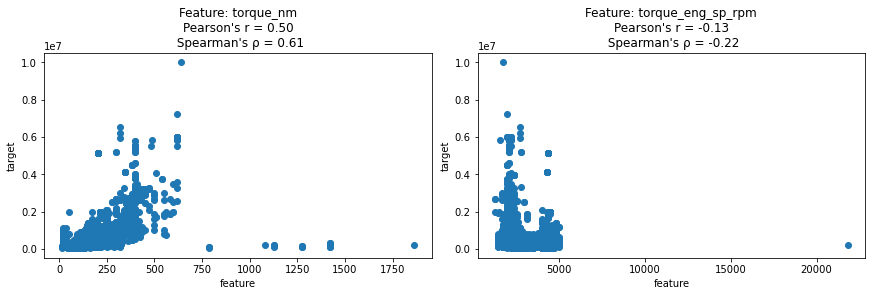

In [25]:
plot_col_signif(raw_data_1, ['torque_nm', 'torque_eng_sp_rpm', 'cost_of_km'], 'selling_price', 1, 2)

*torque_...* columns seem to have outliers, for now we will ignore them.

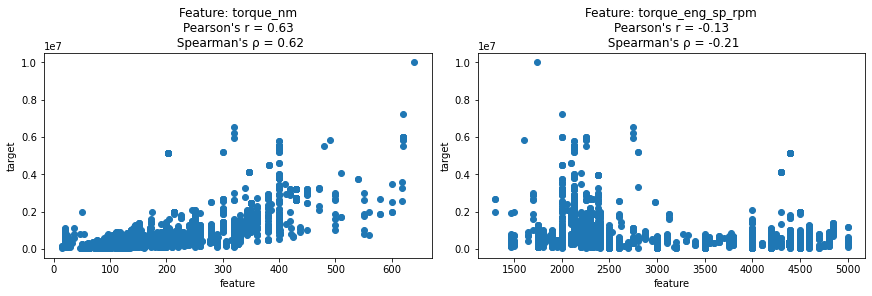

In [26]:
plot_col_signif(raw_data_1[raw_data_1['torque_nm'] < 750], ['torque_nm', 'torque_eng_sp_rpm'], 'selling_price', 1, 2)

*torque_eng_sp_rpm* column has low correlation coefficients, so we can confidently drop it. However *torque_nm* moderately correlated with target column, so let's explore correlation coefficients of *selling_price* and *torque_nm* with other columns.

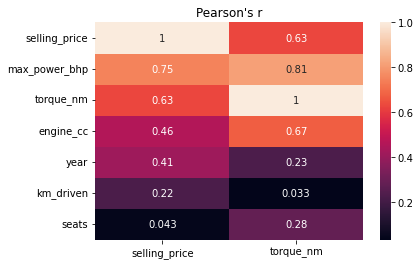

In [27]:
raw_data_1.drop(columns='torque_eng_sp_rpm', inplace=True)

ax = sns.heatmap(
    raw_data_1[raw_data_1['torque_nm'] < 750].corr()[['selling_price', 'torque_nm']].abs().sort_values('selling_price',ascending=False),
    annot=True
)
ax.set_title('Pearson\'s r')
plt.show()

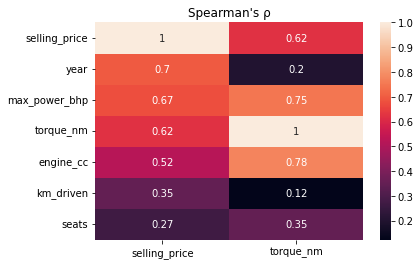

In [28]:
ax = sns.heatmap(
    raw_data_1[raw_data_1['torque_nm'] < 750].corr(method='spearman')[['selling_price', 'torque_nm']].abs().sort_values('selling_price',ascending=False),
    annot=True
)
ax.set_title('Spearman\'s ρ')
plt.show()

Correlation matrixes show that *torque_nm* has one of the highest correlation coefficients with target column in comparison with other features. At the same time it is highly correlated with *max_power_bhp*, which has even higher correlation coefficients with target column. 

Since filling value for *torque_nm* column in second dataset is a time-consuming process and there is a field in the dataset which highly correlates with it, we will drop this column from the first dataset.

In [29]:
raw_data_1.drop(columns='torque_nm', inplace=True)

## Data cleaning of Used Car Prices in India dataset
First of all, we will delete *mileage* coumn, since we did so in the 1st dataset.

In [30]:
raw_data_2.drop(columns=['mileage'], inplace=True)

Let's explore data types of fields in 2st dataset.

In [31]:
raw_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20026 entries, 0 to 20025
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Source.Name            20026 non-null  object 
 1   web-scraper-order      20026 non-null  object 
 2   web-scraper-start-url  20026 non-null  object 
 3   name                   19980 non-null  object 
 4   selling_price          19980 non-null  object 
 5   new-price              9566 non-null   object 
 6   year                   19980 non-null  float64
 7   seller_type            19980 non-null  object 
 8   km_driven              19980 non-null  object 
 9   owner                  19980 non-null  object 
 10  fuel                   19980 non-null  object 
 11  transmission           19980 non-null  object 
 12  engine                 19921 non-null  object 
 13  max_power              19921 non-null  object 
 14  seats                  19853 non-null  object 
dtypes:

### Dropping *new-price* columns
Before moving forward, the output of code cell above shows that *new-price* column contains more than 50% of null values in second dataset. We will print links (*web-scraper-start-url* column) of first five cars where *new-price* column is not null to check if the value of this field is present on webpage.

In [32]:
for i in range(5):
    print(raw_data_2.loc[~raw_data_2['new-price'].isnull()].reset_index()['web-scraper-start-url'][i])

https://www.cardekho.com/used-car-details/used-Hyundai-Grand-i10-2013-2016-Asta-cars-Bhimavaram_8360E6C15B494B8D81470A46DE7FEC94.htm
https://www.cardekho.com/used-car-details/used-Ford-Ecosport-2015-2021-1.5-TDCi-Titanium-BSIV-cars-New-Delhi_70CFDFB8C5EACAC997CFB0DC4CB6CFAC.htm
https://www.cardekho.com/used-car-details/used-Maruti-Wagon-R-2010-2012-VXI-BS-IV-cars-North-lakhimpur_37376C38F689E7DCD6EE987EEB2C1EA2.htm
https://www.cardekho.com/used-car-details/used-Hyundai-i10-2007-2010-Sportz-1.2-cars-Gurgaon_EC67BD3704964EDFAE06B5DD7BDDEA44.htm
https://www.cardekho.com/used-car-details/used-Maruti-Wagon-R-VXI-BS-IV-cars-Ghaziabad_DD1C0A52D7B568846FDBD1CDFCB10A54.htm


At the time of writing, only 2 of 5 webpages still contain information about price of new car (see screenshots below). The reason of disappearance of this information may be that it is based on current offers of new cars on CarDekho website.

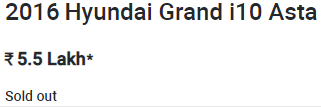

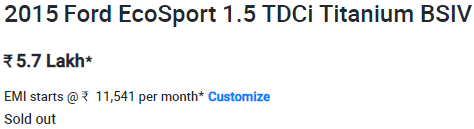

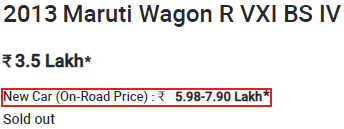

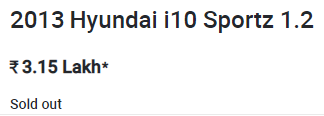

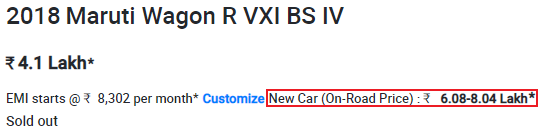

As a result, it will be hard and time-consuming to fill null values for *new-price* column in both datasets, so we will drop this field.

In [33]:
raw_data_2.drop(columns='new-price', inplace=True)

### Convering corresponding columns to right data types

Now let's return to exploring data types of fields in 2st dataset.

In [34]:
raw_data_2.head()

,Source.Name,web-scraper-order,web-scraper-start-url,name,selling_price,year,seller_type,km_driven,owner,fuel,transmission,engine,max_power,seats
0,cardekho_extract(0-2000).csv,1611917819-1662,https://www.cardekho.com/used-car-details/used...,Maruti Alto Std,1.2 Lakh*,2012.0,Individual,"1,20,000 kms",First Owner,Petrol,Manual,Engine796 CC,Max Power46.3 bhp,Seats5
1,cardekho_extract(0-2000).csv,1611918361-1902,https://www.cardekho.com/used-car-details/used...,Hyundai Grand i10 Asta,5.5 Lakh*,2016.0,Individual,"20,000 kms",First Owner,Petrol,Manual,Engine1197 CC,Max Power82 bhp,Seats5
2,cardekho_extract(0-2000).csv,1611917012-1306,https://www.cardekho.com/used-car-details/used...,Hyundai i20 Asta,2.15 Lakh*,2010.0,Individual,"60,000 kms",First Owner,Petrol,Manual,Engine1197 CC,Max Power80 bhp,Seats5
3,cardekho_extract(0-2000).csv,1611917695-1607,https://www.cardekho.com/used-car-details/used...,Maruti Alto K10 2010-2014 VXI,2.26 Lakh*,2012.0,Individual,"37,000 kms",First Owner,Petrol,Manual,Engine998 CC,Max Power67.1 bhp,Seats5
4,cardekho_extract(0-2000).csv,1611914861-367,https://www.cardekho.com/used-car-details/used...,Ford Ecosport 2015-2021 1.5 TDCi Titanium BSIV,5.7 Lakh*,2015.0,Dealer,"30,000 kms",First Owner,Diesel,Manual,Engine1498 CC,Max Power98.59 bhp,Seats5


In [35]:
raw_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20026 entries, 0 to 20025
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Source.Name            20026 non-null  object 
 1   web-scraper-order      20026 non-null  object 
 2   web-scraper-start-url  20026 non-null  object 
 3   name                   19980 non-null  object 
 4   selling_price          19980 non-null  object 
 5   year                   19980 non-null  float64
 6   seller_type            19980 non-null  object 
 7   km_driven              19980 non-null  object 
 8   owner                  19980 non-null  object 
 9   fuel                   19980 non-null  object 
 10  transmission           19980 non-null  object 
 11  engine                 19921 non-null  object 
 12  max_power              19921 non-null  object 
 13  seats                  19853 non-null  object 
dtypes: float64(1), object(13)
memory usage: 2.1+ MB


Columns *selling_price, new-price, km_driven, engine, max_power* and *seats* have wrong data type (object instead of numeric). In the code cells below, we will convert them to numeric data types by following next steps:
1. Remove heading words from * engine, max_power, seats* columns;
2. Remove commas from *km_driven* column;
3. Split *selling_price, km_driven, engine, max_power* into value (*..._val*) and unit (*..._unit*) columns;
4. Convert value columns to numeric data type;
5. Transform value and unit columns to unified unit;
6. Drop original and *..._unit* columns.

In [36]:
# step 1
for col, word in zip(['engine', 'max_power', 'seats'], ['Engine', 'Max Power', 'Seats']):
    raw_data_2[col] = raw_data_2[col].str.replace(word,'').str.strip('\n')

# step 2
raw_data_2['km_driven'] = raw_data_2['km_driven'].str.replace(',','')

# step 3
conv_cols_2 = ['selling_price', 'km_driven', 'engine', 'max_power']
raw_data_2 = split_val_unit(raw_data_2, conv_cols_2)

raw_data_2.head()

Error (engine column):
Columns must be same length as key


,Source.Name,web-scraper-order,web-scraper-start-url,name,selling_price,year,seller_type,km_driven,owner,fuel,transmission,engine,max_power,seats,selling_price_val,selling_price_unit,km_driven_val,km_driven_unit,max_power_val,max_power_unit
0,cardekho_extract(0-2000).csv,1611917819-1662,https://www.cardekho.com/used-car-details/used...,Maruti Alto Std,1.2 Lakh*,2012.0,Individual,120000 kms,First Owner,Petrol,Manual,796 CC,46.3 bhp,5,1.2,Lakh*,120000,kms,46.3,bhp
1,cardekho_extract(0-2000).csv,1611918361-1902,https://www.cardekho.com/used-car-details/used...,Hyundai Grand i10 Asta,5.5 Lakh*,2016.0,Individual,20000 kms,First Owner,Petrol,Manual,1197 CC,82 bhp,5,5.5,Lakh*,20000,kms,82,bhp
2,cardekho_extract(0-2000).csv,1611917012-1306,https://www.cardekho.com/used-car-details/used...,Hyundai i20 Asta,2.15 Lakh*,2010.0,Individual,60000 kms,First Owner,Petrol,Manual,1197 CC,80 bhp,5,2.15,Lakh*,60000,kms,80,bhp
3,cardekho_extract(0-2000).csv,1611917695-1607,https://www.cardekho.com/used-car-details/used...,Maruti Alto K10 2010-2014 VXI,2.26 Lakh*,2012.0,Individual,37000 kms,First Owner,Petrol,Manual,998 CC,67.1 bhp,5,2.26,Lakh*,37000,kms,67.1,bhp
4,cardekho_extract(0-2000).csv,1611914861-367,https://www.cardekho.com/used-car-details/used...,Ford Ecosport 2015-2021 1.5 TDCi Titanium BSIV,5.7 Lakh*,2015.0,Dealer,30000 kms,First Owner,Diesel,Manual,1498 CC,98.59 bhp,5,5.7,Lakh*,30000,kms,98.59,bhp


*split_val_unit()* function returned error for *engine* column. Let's explore why by taking a look at the split of this column.

In [37]:
tmp = raw_data_2['engine'].str.split(expand=True)
tmp.head()

,0,1,2,3
0,796,CC,None,None
1,1197,CC,None,None
2,1197,CC,None,None
3,998,CC,None,None
4,1498,CC,None,None


*engine* column contain messy data. We will print unique values of 2nd-4th elements of split, which may help us in finding rows with mistakes later.

In [38]:
for i in range(3):
    print(f'>>> Split element №{i+2}')
    print(raw_data_2['engine'].str.split(expand=True).iloc[:,i+1].value_counts())
    print()

>>> Split element №2
CC         19875
SizeN/A       29
Size17        15
Name: 1, dtype: int64

>>> Split element №3
x    15
Name: 2, dtype: int64

>>> Split element №4
7.5J    15
Name: 3, dtype: int64



Rows with messy data contain 'SizeN/A' or 'Size17' as 2nd element of *engine* split. Let's take a look at them.

In [39]:
raw_data_2[tmp.iloc[:,1].isin(['SizeN/A', 'Size17'])].head()

,Source.Name,web-scraper-order,web-scraper-start-url,name,selling_price,year,seller_type,km_driven,owner,fuel,transmission,engine,max_power,seats,selling_price_val,selling_price_unit,km_driven_val,km_driven_unit,max_power_val,max_power_unit
718,cardekho_extract(0-2000).csv,1611914302-120,https://www.cardekho.com/used-car-details/used...,BMW 5 Series 520d Sedan,13.5 Lakh*,2010.0,Dealer,65000 kms,First Owner,Diesel,Automatic,Wheel Size17 x 7.5J,Seats5,NaN,13.5,Lakh*,65000,kms,Seats5,None
1599,cardekho_extract(0-2000).csv,1611915494-639,https://www.cardekho.com/used-car-details/used...,BMW X3 2.0d SAV,10.15 Lakh*,2011.0,Dealer,68000 kms,First Owner,Diesel,Automatic,Wheel SizeN/A,Seats5,NaN,10.15,Lakh*,68000,kms,Seats5,None
2464,cardekho_extract(10001-13000).csv,1612147603-920,https://www.cardekho.com/used-car-details/used...,BMW 5 Series 520d Sedan,13.65 Lakh*,2012.0,Dealer,68000 kms,First Owner,Diesel,Automatic,Wheel Size17 x 7.5J,Seats5,NaN,13.65,Lakh*,68000,kms,Seats5,None
2627,cardekho_extract(10001-13000).csv,1612151201-2533,https://www.cardekho.com/used-car-details/used...,Hyundai Santro Xing XG,"70,000*",2004.0,Individual,120000 kms,First Owner,Petrol,Manual,Wheel SizeN/A,Seats5,NaN,"70,000*",None,120000,kms,Seats5,None
4237,cardekho_extract(10001-13000).csv,1612149890-1942,https://www.cardekho.com/used-car-details/used...,BMW 5 Series 520d Sedan,12.99 Lakh*,2011.0,Dealer,33233 kms,First Owner,Diesel,Automatic,Wheel Size17 x 7.5J,Seats5,NaN,12.99,Lakh*,33233,kms,Seats5,None


Output of code cell above shows that:
* *selling_price* also have values with xx,xxx* format, which should be taken into account when we split this column;
* in this slice of data:
    * *engine* contains wrong data;
    * data from *max_power* should be in *seats* column;

Let's fix these problems in the code cell below and repeat splitting of values.

In [40]:
# fix found issues with data
## xx,xxx* format in selling_price
with warnings.catch_warnings(): # suppress warning about future updates for regex in pandas
    warnings.simplefilter(action='ignore', category=FutureWarning)
    raw_data_2['selling_price'] = raw_data_2['selling_price'].str.replace(',','').str.replace('\d\*','0 *', regex=True)
## data from max_power should be in seats column
raw_data_2.loc[tmp.iloc[:,1].isin(['SizeN/A', 'Size17']), 'seats'] = raw_data_2.loc[tmp.iloc[:,1].isin(['SizeN/A', 'Size17']), 'max_power'] 
## removing incorret data from 'engine' and 'max_power' columns
raw_data_2.loc[tmp.iloc[:,1].isin(['SizeN/A', 'Size17']), ['engine', 'max_power']] = np.nan

# repeat step 1 and 3 after fix in 'engine', 'max_power', 'seats' columns
for col, word in zip(['engine', 'max_power', 'seats'], ['Engine', 'Max Power', 'Seats']):
    raw_data_2[col] = raw_data_2[col].str.replace(word,'').str.strip('\n')

raw_data_2 = split_val_unit(raw_data_2, conv_cols_2)

# step 4
## while/try/except helps find all exceptions and deal with them
def df_float(df, cols):
    data = df.copy()
    flg = True
    while flg:
        try:
            data = data.astype({col:float for col in cols})
            flg = False
        except Exception as e:
            error_val = str(e).replace("could not convert string to float: '", "").strip("'")
            data[cols] = data[cols].replace({error_val:np.nan})
            print('Fixed: '+str(e))
            
    return data


num_cols_2 = [name+'_val' for name in conv_cols_2]+['seats']
raw_data_2 = df_float(raw_data_2, num_cols_2)
print()

# step 5
list_value_counts(raw_data_2, [col+'_unit' for col in conv_cols_2])

Fixed: could not convert string to float: 'N/A'
Fixed: could not convert string to float: 'null'
Fixed: could not convert string to float: 'bhp'
Fixed: could not convert string to float: 'CC'

<======= selling_price_unit =======>
Lakh*    19702
*          267
Cr*         11
Name: selling_price_unit, dtype: int64

<======= km_driven_unit =======>
kms    19980
Name: km_driven_unit, dtype: int64

<======= engine_unit =======>
CC    19875
Name: engine_unit, dtype: int64

<======= max_power_unit =======>
bhp    19874
Name: max_power_unit, dtype: int64



*selling_price* column have more than one unit, so we will convert *selling_price* to 'inr' unit (code for Indian Rupee).

In [41]:
# continuation of step 5
raw_data_2.loc[raw_data_2['selling_price_unit'] == 'Cr*', 'selling_price_val'] = 10**7 * raw_data_2.loc[raw_data_2['selling_price_unit'] == 'Cr*', 'selling_price_val']
raw_data_2.loc[raw_data_2['selling_price_unit'] == 'Lakh*', 'selling_price_val'] = 10**5 * raw_data_2.loc[raw_data_2['selling_price_unit'] == 'Lakh*', 'selling_price_val']
raw_data_2['selling_price_unit'] = 'inr'

list_value_counts(raw_data_2, [col+'_unit' for col in conv_cols_2])

<======= selling_price_unit =======>
inr    20026
Name: selling_price_unit, dtype: int64

<======= km_driven_unit =======>
kms    19980
Name: km_driven_unit, dtype: int64

<======= engine_unit =======>
CC    19875
Name: engine_unit, dtype: int64

<======= max_power_unit =======>
bhp    19874
Name: max_power_unit, dtype: int64



In [42]:
# step 6
raw_data_2 = clear_val_unit_cols(raw_data_2, conv_cols_2)

raw_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20026 entries, 0 to 20025
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Source.Name            20026 non-null  object 
 1   web-scraper-order      20026 non-null  object 
 2   web-scraper-start-url  20026 non-null  object 
 3   name                   19980 non-null  object 
 4   year                   19980 non-null  float64
 5   seller_type            19980 non-null  object 
 6   owner                  19980 non-null  object 
 7   fuel                   19980 non-null  object 
 8   transmission           19980 non-null  object 
 9   seats                  19893 non-null  float64
 10  selling_price_inr      19980 non-null  float64
 11  km_driven_kms          19980 non-null  float64
 12  max_power_bhp          19643 non-null  float64
 13  engine_cc              19875 non-null  float64
dtypes: float64(6), object(8)
memory usage: 2.1+ MB


In [43]:
raw_data_2.head()

,Source.Name,web-scraper-order,web-scraper-start-url,name,year,seller_type,owner,fuel,transmission,seats,selling_price_inr,km_driven_kms,max_power_bhp,engine_cc
0,cardekho_extract(0-2000).csv,1611917819-1662,https://www.cardekho.com/used-car-details/used...,Maruti Alto Std,2012.0,Individual,First Owner,Petrol,Manual,5.0,120000.0,120000.0,46.30,796.0
1,cardekho_extract(0-2000).csv,1611918361-1902,https://www.cardekho.com/used-car-details/used...,Hyundai Grand i10 Asta,2016.0,Individual,First Owner,Petrol,Manual,5.0,550000.0,20000.0,82.00,1197.0
2,cardekho_extract(0-2000).csv,1611917012-1306,https://www.cardekho.com/used-car-details/used...,Hyundai i20 Asta,2010.0,Individual,First Owner,Petrol,Manual,5.0,215000.0,60000.0,80.00,1197.0
3,cardekho_extract(0-2000).csv,1611917695-1607,https://www.cardekho.com/used-car-details/used...,Maruti Alto K10 2010-2014 VXI,2012.0,Individual,First Owner,Petrol,Manual,5.0,226000.0,37000.0,67.10,998.0
4,cardekho_extract(0-2000).csv,1611914861-367,https://www.cardekho.com/used-car-details/used...,Ford Ecosport 2015-2021 1.5 TDCi Titanium BSIV,2015.0,Dealer,First Owner,Diesel,Manual,5.0,570000.0,30000.0,98.59,1498.0


### Managing non-corresponding columns
*Source.Name* and *web-scraper-order* columns will be droped since they carry no information about cars. *web-scraper-start-url* column will be left for now, since it may help us in dealing with outliers and null-values, but we will rename it to 'url' for convenience.

In [44]:
raw_data_2.drop(columns=['Source.Name', 'web-scraper-order'], inplace=True)
raw_data_2.rename(columns={'web-scraper-start-url':'url'}, inplace=True)
raw_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20026 entries, 0 to 20025
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   url                20026 non-null  object 
 1   name               19980 non-null  object 
 2   year               19980 non-null  float64
 3   seller_type        19980 non-null  object 
 4   owner              19980 non-null  object 
 5   fuel               19980 non-null  object 
 6   transmission       19980 non-null  object 
 7   seats              19893 non-null  float64
 8   selling_price_inr  19980 non-null  float64
 9   km_driven_kms      19980 non-null  float64
 10  max_power_bhp      19643 non-null  float64
 11  engine_cc          19875 non-null  float64
dtypes: float64(6), object(6)
memory usage: 1.8+ MB


## Combining the datasets

Let's check if all columns are corresponding in both datasets before combining them.

In [45]:
compare_cols(raw_data_1, raw_data_2)

Corresponding columns (9):
   > engine_cc
   > fuel
   > max_power_bhp
   > name
   > owner
   > seats
   > seller_type
   > transmission
   > year
Columns from 1st dataset, which are not present in 2nd (2):
   > km_driven
   > selling_price
Columns from 2nd dataset, which are not present in 1st (3):
   > km_driven_kms
   > selling_price_inr
   > url


We will rename *km_driven_kms, selling_price* columns to *km_driven, selling_price_inr* and add *url* column with null values in 1st dataset.

In [46]:
raw_data_1.rename(columns={'selling_price':'selling_price_inr'}, inplace=True)
raw_data_2.rename(columns={'km_driven_kms':'km_driven'}, inplace=True)
raw_data_1['url'] = np.nan
compare_cols(raw_data_1, raw_data_2)
print()
raw_data_1.info()

Corresponding columns (12):
   > engine_cc
   > fuel
   > km_driven
   > max_power_bhp
   > name
   > owner
   > seats
   > seller_type
   > selling_price_inr
   > transmission
   > url
   > year
Columns from 1st dataset, which are not present in 2nd (0):
Columns from 2nd dataset, which are not present in 1st (0):

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               8128 non-null   object 
 1   year               8128 non-null   int64  
 2   selling_price_inr  8128 non-null   int64  
 3   km_driven          8128 non-null   int64  
 4   fuel               8128 non-null   object 
 5   seller_type        8128 non-null   object 
 6   transmission       8128 non-null   object 
 7   owner              8128 non-null   object 
 8   seats              7907 non-null   float64
 9   engine_cc          7907 non-null   float64


Now we are ready to concatanate the datasets.

In [47]:
raw_data = pd.concat([raw_data_1, raw_data_2], ignore_index = True)
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28154 entries, 0 to 28153
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               28108 non-null  object 
 1   year               28108 non-null  float64
 2   selling_price_inr  28108 non-null  float64
 3   km_driven          28108 non-null  float64
 4   fuel               28108 non-null  object 
 5   seller_type        28108 non-null  object 
 6   transmission       28108 non-null  object 
 7   owner              28108 non-null  object 
 8   seats              27800 non-null  float64
 9   engine_cc          27782 non-null  float64
 10  max_power_bhp      27555 non-null  float64
 11  url                20026 non-null  object 
dtypes: float64(6), object(6)
memory usage: 2.6+ MB


Before moving forward, we will convert seats to object data type, because for car number of seats is a categorical field.

In [48]:
raw_data = raw_data.astype({'seats':str})
# remove '.0' left from float data type 
raw_data['seats'] = raw_data['seats'].str.replace('.0','', regex=False).replace({'nan':np.nan})
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28154 entries, 0 to 28153
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               28108 non-null  object 
 1   year               28108 non-null  float64
 2   selling_price_inr  28108 non-null  float64
 3   km_driven          28108 non-null  float64
 4   fuel               28108 non-null  object 
 5   seller_type        28108 non-null  object 
 6   transmission       28108 non-null  object 
 7   owner              28108 non-null  object 
 8   seats              27800 non-null  object 
 9   engine_cc          27782 non-null  float64
 10  max_power_bhp      27555 non-null  float64
 11  url                20026 non-null  object 
dtypes: float64(5), object(7)
memory usage: 2.6+ MB


## Managing duplicate rows
Let's check if data contains any duplicate rows and drop them.

In [49]:
print("Number of rows before cleaning duplicates:", raw_data.shape[0])
cols_no_url = list(raw_data.columns)
cols_no_url.remove('url')
raw_data.drop_duplicates(subset=cols_no_url, inplace=True, ignore_index=True)
print("Number of rows after cleaning duplicates:", raw_data.shape[0])

Number of rows before cleaning duplicates: 28154
Number of rows after cleaning duplicates: 26719


## Managing outliers

### Numeric fields: Boxplot diagrams
Let's take a look at possible numeric outliers by plotting boxplot diagrams for numeric fields.

In [50]:
def plot_whiskers(df, numeric_cols = None, n_rows=None, n_cols=None):
    if numeric_cols is None:
        numeric_cols = list(df.select_dtypes(include='number').columns)
        
    if n_rows is None or n_cols is None:
        n_cols = 2
        n_rows = ceil(len(numeric_cols) / 2)
    
    fig, axes = plt.subplots(nrows = n_rows, ncols = n_cols, figsize=(6*n_cols,4*n_rows), squeeze=False, constrained_layout = True)
    
    plt.suptitle('Boxplots', fontsize='xx-large', fontweight='bold')
    for i in range(n_rows):
        for j in range(n_cols):            
            try:
                col = numeric_cols[i*n_cols+j]
            except:
                plt.show()
                return

            sns.boxplot(data=df, x=col, orient='h', ax=axes[i,j])
            #clear xlabel
            axes[i,j].set_xlabel('')
            axes[i,j].set_title(f'{col}', fontsize='xx-large')

    plt.show()

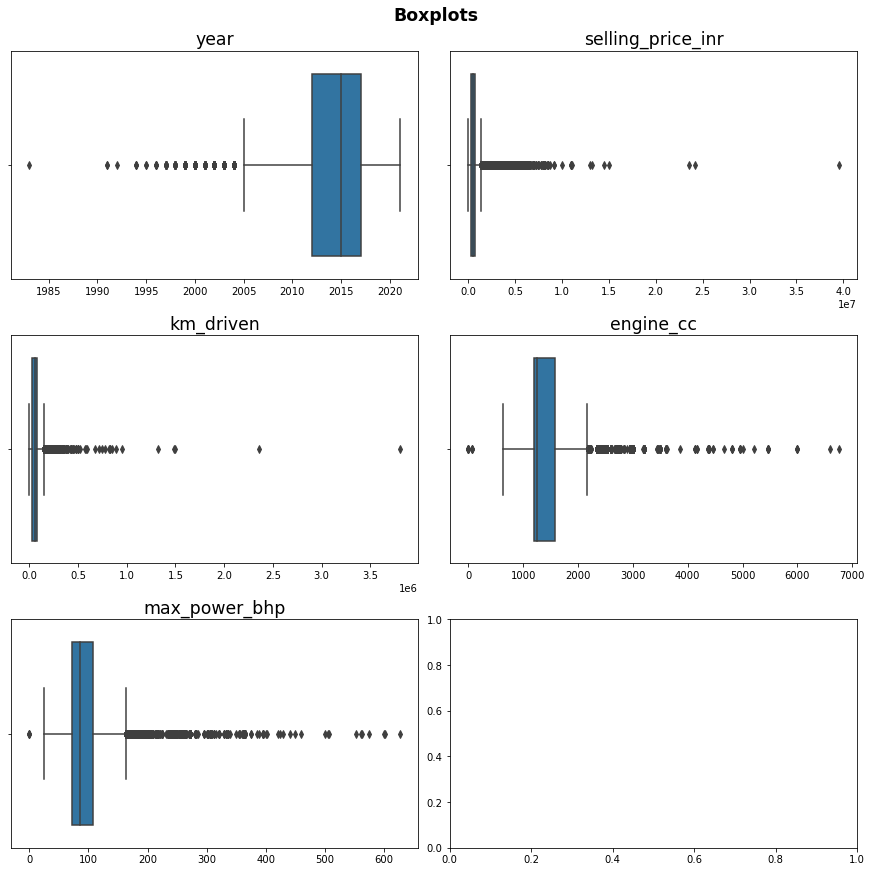

In [51]:
plot_whiskers(raw_data)

The suspicious values which we will explore further are:
* *selling_price_inr > 20,000,000*
* *km_driven > 1,000,000*
* *engine_cc < 400*
* *max_power_bhp = 0*

#### *selling_price_inr > 20,000,000*

In [52]:
raw_data[raw_data['selling_price_inr'] > 2 * 10**7]

,name,year,selling_price_inr,km_driven,fuel,seller_type,transmission,owner,seats,engine_cc,max_power_bhp,url
7399,Bentley Mulsanne 6.8,2012.0,23500000.0,15000.0,Petrol,Dealer,Automatic,First Owner,5,6752.0,505.0,https://www.cardekho.com/used-car-details/used...
11868,Ferrari GTC4Lusso T,2019.0,39500000.0,3800.0,Petrol,Dealer,Automatic,First Owner,4,3855.0,601.0,https://www.cardekho.com/used-car-details/used...
21065,Rolls-Royce Ghost Series II Extended Wheelbase,2017.0,24200000.0,5000.0,Petrol,Individual,Automatic,First Owner,4,6592.0,563.0,https://www.cardekho.com/used-car-details/used...


These cars have such high price because they are from premium class, so these outliers are not caused by error in data. However, leaving them may harm accuracy of our model on more general examples, so we will drop these rows. 

In [53]:
raw_data = raw_data[~(raw_data['selling_price_inr'] >= 2 * 10**7)]

#### *km_driven > 1,000,000*

In [54]:
raw_data[raw_data['km_driven'] > 10**6]

,name,year,selling_price_inr,km_driven,fuel,seller_type,transmission,owner,seats,engine_cc,max_power_bhp,url
1646,Mahindra XUV500 W6 2WD,2012.0,500000.0,1500000.0,Diesel,Individual,Manual,First Owner,7,2179.0,140.00,NaN
3161,Hyundai i20 Asta 1.2,2007.0,550000.0,2360457.0,Petrol,Individual,Manual,Second Owner,5,1197.0,81.83,NaN
22233,Mercedes-Benz E-Class E350 Diesel,2012.0,1350000.0,1325000.0,Diesel,Dealer,Automatic,First Owner,5,2987.0,210.00,https://www.cardekho.com/used-car-details/used...
24684,Honda CR-V AT With Sun Roof,2015.0,1485000.0,1485000.0,Petrol,Dealer,Automatic,First Owner,5,NaN,NaN,https://www.cardekho.com/used-car-details/used...
26717,Mahindra XUV500 W6 2WD,2016.0,1225000.0,3800000.0,Diesel,Dealer,Manual,First Owner,7,2179.0,140.00,https://www.cardekho.com/used-car-details/used...


These values also seem to be right, but leaving them may harm accuracy of our model on more general examples, so we will drop these rows. 

In [55]:
raw_data = raw_data[~(raw_data['km_driven'] > 10**6)]

#### *engine_cc < 400*

In [56]:
raw_data[raw_data['engine_cc'] < 400]

,name,year,selling_price_inr,km_driven,fuel,seller_type,transmission,owner,seats,engine_cc,max_power_bhp,url
9258,Mahindra E Verito D2,2020.0,945000.0,2746.0,Electric,Dealer,Automatic,First Owner,5,72.0,41.57,https://www.cardekho.com/used-car-details/used...
22474,Mahindra e2o T2,2015.0,360000.0,42862.0,Electric,Dealer,Automatic,First Owner,5,0.0,25.50,https://www.cardekho.com/used-car-details/used...
24162,Mahindra E Verito D2,2019.0,1197000.0,18281.0,Electric,Individual,Automatic,First Owner,5,72.0,41.57,https://www.cardekho.com/used-car-details/used...
24547,Mahindra e2o T2,2015.0,450000.0,40000.0,Electric,Dealer,Automatic,First Owner,5,0.0,25.50,https://www.cardekho.com/used-car-details/used...
25157,Mahindra e2o Premium,2013.0,325000.0,50000.0,Electric,Individual,Automatic,First Owner,5,0.0,25.50,https://www.cardekho.com/used-car-details/used...
25844,Mahindra E Verito D6,2020.0,725000.0,8200.0,Electric,Dealer,Automatic,First Owner,5,72.0,41.57,https://www.cardekho.com/used-car-details/used...
25864,Tata Nexon EV XM,2021.0,1399000.0,5000.0,Electric,Individual,Automatic,First Owner,5,0.0,127.00,https://www.cardekho.com/used-car-details/used...
26514,Hyundai Kona Premium,2019.0,2175000.0,6000.0,Electric,Dealer,Automatic,First Owner,5,0.0,134.10,https://www.cardekho.com/used-car-details/used...


All cars with *engine_cc < 400* are electric. This can be explained by the fact that electric cars have motor instead of engine, so they should contain null values in *engine_cc*. Before moving forward, let's check if all non-null values in *engine_cc* are lower than 400 for electric cars.

In [57]:
raw_data[(raw_data['fuel']=='Electric') & (raw_data['engine_cc'] >= 400)]

,name,year,selling_price_inr,km_driven,fuel,seller_type,transmission,owner,seats,engine_cc,max_power_bhp,url
9533,Toyota Camry Hybrid,2015.0,1850000.0,49500.0,Electric,Dealer,Automatic,First Owner,5,2494.0,157.7,https://www.cardekho.com/used-car-details/used...
21890,Toyota Camry Hybrid,2015.0,2000000.0,60000.0,Electric,Individual,Automatic,First Owner,5,2494.0,157.7,https://www.cardekho.com/used-car-details/used...
25319,Toyota Camry Hybrid,2016.0,1865000.0,85000.0,Electric,Dealer,Automatic,First Owner,5,2494.0,157.7,https://www.cardekho.com/used-car-details/used...
25673,Toyota Camry Hybrid,2015.0,1699000.0,64000.0,Electric,Dealer,Automatic,First Owner,5,2494.0,157.7,https://www.cardekho.com/used-car-details/used...


Values of *fuel* in above data slice are probably incorrect, since hybrid cars use petrol as main fuel. We will fix it in the next code cell and assign null value to *engine_cc*, where *engine_cc < 400*.

In [58]:
raw_data.loc[raw_data['name']=='Toyota Camry Hybrid', 'fuel'] = 'Petrol'
raw_data.loc[raw_data['engine_cc'] < 400, 'engine_cc'] = np.nan

#### *max_power_bhp = 0*

In [59]:
raw_data[raw_data['max_power_bhp'] == 0]

,name,year,selling_price_inr,km_driven,fuel,seller_type,transmission,owner,seats,engine_cc,max_power_bhp,url
547,Maruti Alto K10 LXI,2011.0,204999.0,97500.0,Petrol,Individual,Manual,First Owner,NaN,NaN,0.0,NaN
1309,Maruti Swift Dzire VDI Optional,2017.0,589000.0,41232.0,Diesel,Dealer,Manual,First Owner,NaN,NaN,0.0,NaN
2352,Tata Indica Vista Quadrajet LS,2012.0,240000.0,70000.0,Diesel,Individual,Manual,First Owner,NaN,NaN,0.0,NaN


Obviously, '0' values in *max_power_bhp* should be replaced with null.

In [60]:
raw_data.loc[raw_data['max_power_bhp'] == 0, 'max_power_bhp'] = np.nan

We will plot boxplot diagrams again to make sure that we've done everything correct.

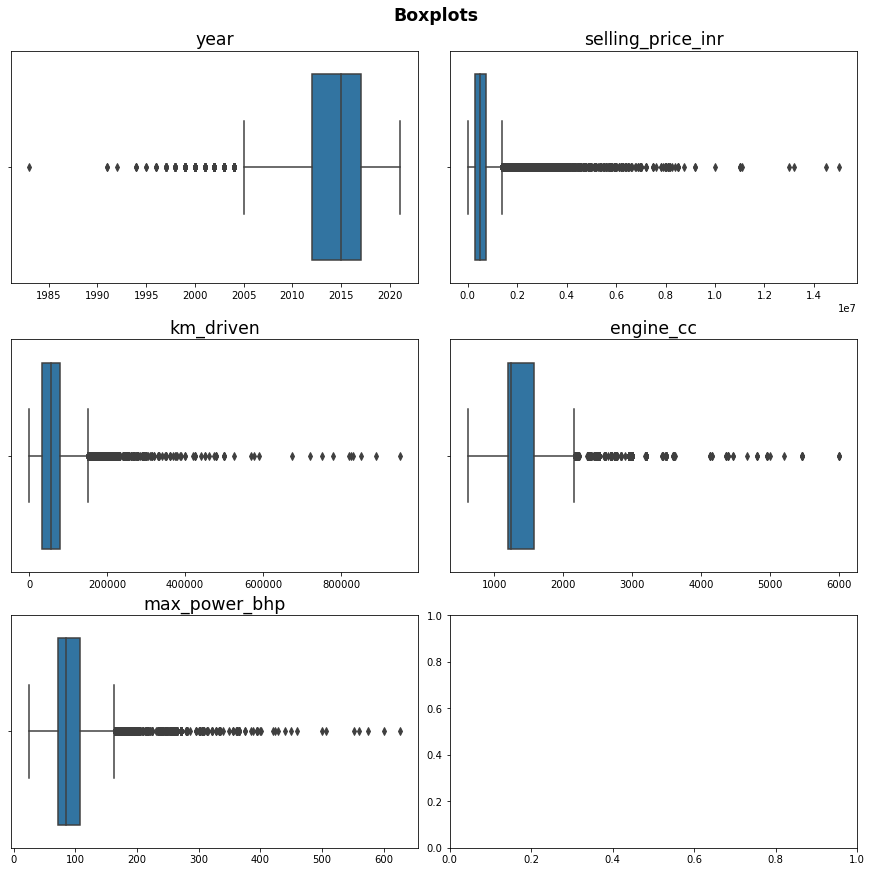

In [61]:
plot_whiskers(raw_data)

### Numeric fields: Descriptive statistics
As a last check of numeric fields we will take a look at their descriptive statistics.

In [62]:
raw_data.describe()

,year,selling_price_inr,km_driven,engine_cc,max_power_bhp
count,26710.000000,2.671000e+04,26710.000000,26391.000000,26166.000000
mean,2014.234107,6.779439e+05,61981.228529,1465.231291,96.370949
std,3.518585,7.730217e+05,44583.440222,510.763174,40.990499
min,1983.000000,2.500000e+04,1.000000,624.000000,25.400000
25%,2012.000000,3.100000e+05,33000.000000,1197.000000,72.000000
50%,2015.000000,4.950000e+05,55309.500000,1248.000000,85.800000
75%,2017.000000,7.450000e+05,80000.000000,1582.000000,108.490000
max,2021.000000,1.500000e+07,950000.000000,5998.000000,626.000000


Let's examine rows with 5 smallest *km_driven* values.

In [63]:
raw_data.nsmallest(5, 'km_driven')

,name,year,selling_price_inr,km_driven,fuel,seller_type,transmission,owner,seats,engine_cc,max_power_bhp,url
6737,Maruti Eeco 5 STR With AC Plus HTR CNG,2011.0,209000.0,1.0,CNG,Individual,Manual,Fourth & Above Owner,5,1196.0,73.00,NaN
8817,Hyundai Santro Era,2020.0,475000.0,100.0,Petrol,Individual,Manual,First Owner,5,1086.0,68.00,https://www.cardekho.com/used-car-details/used...
19982,Hyundai Venue SX iMT,2020.0,1145000.0,581.0,Petrol,Trustmark Dealer,Manual,First Owner,5,998.0,118.35,https://www.cardekho.com/used-car-details/used...
393,Honda City i-VTEC CVT V,2018.0,1085000.0,1000.0,Petrol,Individual,Automatic,First Owner,5,1497.0,117.60,NaN
2714,Maruti Swift AMT VXI,2020.0,654000.0,1000.0,Petrol,Individual,Automatic,First Owner,5,1197.0,81.80,NaN


It is very unlikely that 4 or more owners have driven 1 km in total from 2011, so we will assign null value to *km_driven* of this row.

In [64]:
raw_data['km_driven'] = raw_data['km_driven'].replace({1.0:np.nan})
raw_data.describe()

,year,selling_price_inr,km_driven,engine_cc,max_power_bhp
count,26710.000000,2.671000e+04,26709.000000,26391.000000,26166.000000
mean,2014.234107,6.779439e+05,61983.549103,1465.231291,96.370949
std,3.518585,7.730217e+05,44582.661700,510.763174,40.990499
min,1983.000000,2.500000e+04,100.000000,624.000000,25.400000
25%,2012.000000,3.100000e+05,33000.000000,1197.000000,72.000000
50%,2015.000000,4.950000e+05,55319.000000,1248.000000,85.800000
75%,2017.000000,7.450000e+05,80000.000000,1582.000000,108.490000
max,2021.000000,1.500000e+07,950000.000000,5998.000000,626.000000


As can be seen, there are no more outliers left in numeric fields.
### Categorical fields
Let's take a look at unique values of categorical fields to see if there are any errors.

In [65]:
categ_cols = ['fuel', 'seller_type', 'transmission', 'owner', 'seats']
list_value_counts(raw_data, categ_cols)

<======= fuel =======>
Diesel      13475
Petrol      12751
CNG           370
LPG           104
Electric       10
Name: fuel, dtype: int64

<======= seller_type =======>
Individual          13936
Dealer              12557
Trustmark Dealer      217
Name: seller_type, dtype: int64

<======= transmission =======>
Manual       22223
Automatic     4487
Name: transmission, dtype: int64

<======= owner =======>
First Owner             24021
Second Owner             1977
Third Owner               538
Fourth & Above Owner      169
Test Drive Car              5
Name: owner, dtype: int64

<======= seats =======>
5     21681
7      3312
8       663
4       345
6       198
9       146
10       44
2        23
14        3
Name: seats, dtype: int64



It is not clear what *owner* = 'Test Drive Car' means, so we will take a look at rows with such value.

In [66]:
raw_data[raw_data['owner'] == 'Test Drive Car']

,name,year,selling_price_inr,km_driven,fuel,seller_type,transmission,owner,seats,engine_cc,max_power_bhp,url
3830,Volkswagen Vento 1.5 TDI Highline BSIV,2019.0,1350000.0,5400.0,Diesel,Dealer,Manual,Test Drive Car,5,1498.0,108.60,NaN
4286,Audi A6 35 TFSI Matrix,2019.0,6223000.0,7800.0,Petrol,Dealer,Automatic,Test Drive Car,5,1798.0,187.74,NaN
4287,Audi A6 35 TFSI Matrix,2019.0,5923000.0,11500.0,Petrol,Dealer,Automatic,Test Drive Car,5,1798.0,187.74,NaN
4288,Audi A6 35 TFSI Matrix,2019.0,6523000.0,23600.0,Petrol,Dealer,Automatic,Test Drive Car,5,1798.0,187.74,NaN
5351,Honda Civic ZX,2019.0,2000000.0,24857.0,Petrol,Dealer,Automatic,Test Drive Car,5,1799.0,139.46,NaN


Since they have low values in *km_driven*, they may be cars used for test driving in car dealership and we will assign them to 'First Owner' group.

In [67]:
raw_data['owner'] = raw_data['owner'].replace({'Test Drive Car':'First Owner'})
list_value_counts(raw_data, ['owner'])

<======= owner =======>
First Owner             24026
Second Owner             1977
Third Owner               538
Fourth & Above Owner      169
Name: owner, dtype: int64



Also we will replace 'Trustmark Dealer' values in *seller_type* with 'Dealer', since they are subcategory of 'Dealer' and ~0.8% of data.

In [68]:
raw_data['seller_type'] = raw_data['seller_type'].replace({'Trustmark Dealer':'Dealer'})

Other categorical columns have understandable and right values.
## Managing null values
Let's take a look at amount of null values in data (without *url* column, since we left only to help us find missing values).

In [69]:
def null_counter(df):
    display(
        pd.DataFrame(
            df.isnull().sum(axis=1).value_counts().sort_index(ascending=False)
        ).reset_index().rename(columns={'index':'n_nulls', 0:'n_rows'})
    )

In [70]:
null_counter(raw_data.loc[:, raw_data.columns != 'url'])

,n_nulls,n_rows
0,11,1
1,3,270
2,2,54
3,1,241
4,0,26145


We'll drop empty row and explore in greater detail other rows with null values.

In [71]:
raw_data = raw_data[raw_data.isnull().sum(axis=1)!=11].reset_index(drop=True)

In [72]:
def n_nulls_cols_counter(df, n_nulls):
    print(
        df[df.isnull().sum(axis=1)==n_nulls].apply(lambda row: frozenset(df.columns[row.isnull()]), axis=1).value_counts()
    )

def all_null_cols_counter(df):
    uniq_n_nulls = sorted(df.isnull().sum(axis=1).unique(), reverse = True)[:-1]
    for n in uniq_n_nulls:
        print('>>> List of columns with null values, where amount of nulls =', n,'<<<')
        n_nulls_cols_counter(df, n)
        print()

In [73]:
all_null_cols_counter(raw_data.loc[:, raw_data.columns != 'url'])

>>> List of columns with null values, where amount of nulls = 3 <<<
(engine_cc, seats, max_power_bhp)    270
dtype: int64

>>> List of columns with null values, where amount of nulls = 2 <<<
(engine_cc, max_power_bhp)    39
(seats, max_power_bhp)        15
dtype: int64

>>> List of columns with null values, where amount of nulls = 1 <<<
(max_power_bhp)    220
(seats)             10
(engine_cc)         10
(km_driven)          1
dtype: int64



First let's deal with null value in *km_driven*, which previously contained an outlier. We will fill it with mean *km_driven* of cars with 'Fourth & Above Owner', since it was the reason why we droped this value.

In [74]:
raw_data.loc[raw_data['km_driven'].isnull(), 'km_driven'] = raw_data.loc[raw_data['owner']=='Fourth & Above Owner', 'km_driven'].mean()
all_null_cols_counter(raw_data.loc[:, raw_data.columns != 'url'])

>>> List of columns with null values, where amount of nulls = 3 <<<
(engine_cc, seats, max_power_bhp)    270
dtype: int64

>>> List of columns with null values, where amount of nulls = 2 <<<
(engine_cc, max_power_bhp)    39
(seats, max_power_bhp)        15
dtype: int64

>>> List of columns with null values, where amount of nulls = 1 <<<
(max_power_bhp)    220
(seats)             10
(engine_cc)         10
dtype: int64



Rest columns with null values are features of car which are not influenced by age. That's why we will try to find values for this fields in other rows by searching the name of the car. 

In [75]:
def fillna_by_col(data, col):
    df = data.copy()
    unique_vals = df.loc[df.isnull().any(axis=1), col].unique()
    for val in unique_vals:
        df[df[col]==val] = df[df[col]==val].ffill().bfill()
    
    return df

In [76]:
raw_data.loc[:, raw_data.columns != 'url'] = fillna_by_col(raw_data.loc[:, raw_data.columns != 'url'], 'name')
null_counter(raw_data.loc[:, raw_data.columns != 'url'])

,n_nulls,n_rows
0,3,121
1,2,63
2,1,208
3,0,26318


Now let's get brand of car from *name* column and fill the remaining null values with mean (*max_power_bhp, engine_cc*) and mode (*seats*) of the corresponding brand cars in the code cells below.

In [77]:
raw_data['brand'] = raw_data['name'].str.split().str[0]
raw_data['brand'].unique()

array(['Maruti', 'Skoda', 'Honda', 'Hyundai', 'Toyota', 'Ford', 'Renault',
       'Mahindra', 'Tata', 'Chevrolet', 'Fiat', 'Datsun', 'Jeep',
       'Mercedes-Benz', 'Mitsubishi', 'Audi', 'Volkswagen', 'BMW',
       'Nissan', 'Lexus', 'Jaguar', 'Land', 'MG', 'Volvo', 'Daewoo',
       'Kia', 'Force', 'Ambassador', 'Ashok', 'Isuzu', 'Opel', 'Peugeot',
       'Mini', 'Porsche', 'Premier', 'Maserati', 'Bentley', 'Lamborghini',
       'ISUZU', 'OpelCorsa', 'Mercedes-AMG', 'DC'], dtype=object)

Next values in new column *brand* should be changed:
* Land -> Land Rover
* Mini -> Mini Cooper
* OpelCorsa -> Opel
* Isuzu -> ISUZU
* Ashok -> Ashok Leyland
* Mercedes-AMG -> Mercedes-Benz

In [78]:
replace_dict = {
    'Land' : 'Land Rover', 
    'Mini' : 'Mini Cooper',
    'OpelCorsa' : 'Opel',
    'Isuzu' : 'ISUZU',
    'Ashok' : 'Ashok Leyland',
    'Mercedes-AMG' : 'Mercedes-Benz'
}
raw_data['brand'] = raw_data['brand'].replace(replace_dict)
raw_data['brand'].unique()

array(['Maruti', 'Skoda', 'Honda', 'Hyundai', 'Toyota', 'Ford', 'Renault',
       'Mahindra', 'Tata', 'Chevrolet', 'Fiat', 'Datsun', 'Jeep',
       'Mercedes-Benz', 'Mitsubishi', 'Audi', 'Volkswagen', 'BMW',
       'Nissan', 'Lexus', 'Jaguar', 'Land Rover', 'MG', 'Volvo', 'Daewoo',
       'Kia', 'Force', 'Ambassador', 'Ashok Leyland', 'ISUZU', 'Opel',
       'Peugeot', 'Mini Cooper', 'Porsche', 'Premier', 'Maserati',
       'Bentley', 'Lamborghini', 'DC'], dtype=object)

In [79]:
def fillna_stat_by_col(data, col, fill_method):
    df = data.copy()
    unique_vals = df.loc[df.isnull().any(axis=1), col].unique()
    for val in unique_vals:
        if fill_method=='mean':
            df[df[col]==val] = df[df[col]==val].fillna(df[df[col]==val].mean(numeric_only=True))
        elif fill_method=='mode':
            df[df[col]==val] = df[df[col]==val].fillna(df[df[col]==val].mode().iloc[0,:])
        else:
            print(f"Error: method '{fill_method}' is incorrect")
            return
    
    return df

In [80]:
print('>>> Before filling null values')
null_counter(raw_data.loc[:, raw_data.columns != 'url'])
raw_data.loc[:, ~raw_data.columns.isin(['url', 'seats'])] = fillna_stat_by_col(
    raw_data.loc[:, ~raw_data.columns.isin(['url', 'seats'])],
    'brand',
    'mean'
)
print('\n>>> After filling null values in engine_cc and max_power_bhp')
null_counter(raw_data.loc[:, raw_data.columns != 'url'])
raw_data.loc[:, raw_data.columns != 'url'] = fillna_stat_by_col(
    raw_data.loc[:, raw_data.columns != 'url'],
    'brand',
    'mode'
)
print('\n>>> After filling null values in seats')
null_counter(raw_data.loc[:, raw_data.columns != 'url'])

>>> Before filling null values


,n_nulls,n_rows
0,3,121
1,2,63
2,1,208
3,0,26318



>>> After filling null values in engine_cc and max_power_bhp


,n_nulls,n_rows
0,3,1
1,1,151
2,0,26558



>>> After filling null values in seats


,n_nulls,n_rows
0,3,1
1,0,26709


Let's take a look at last row with null values.

In [81]:
raw_data.loc[raw_data.drop(columns='url').isnull().any(axis=1), :]

,name,year,selling_price_inr,km_driven,fuel,seller_type,transmission,owner,seats,engine_cc,max_power_bhp,url,brand
5780,Peugeot 309 GLD,1997.0,57000.0,110000.0,Diesel,Individual,Manual,Third Owner,NaN,NaN,NaN,NaN,Peugeot


We will fill these null values with information from [ultimatespecs.com](https://www.ultimatespecs.com/car-specs/Peugeot/1974/Peugeot-309-GLD---GRD.html).

In [82]:
raw_data.loc[raw_data.drop(columns='url').isnull().any(axis=1), ['seats', 'engine_cc', 'max_power_bhp']] = ['5', 1905, 64]
null_counter(raw_data.loc[:, raw_data.columns != 'url'])

,n_nulls,n_rows
0,0,26710


Let's drop *url* column, since we won't need it anymore, and move to exploratory data analysis.

In [83]:
clean_df = raw_data.drop(columns='url')
clean_df.columns

Index(['name', 'year', 'selling_price_inr', 'km_driven', 'fuel', 'seller_type',
       'transmission', 'owner', 'seats', 'engine_cc', 'max_power_bhp',
       'brand'],
      dtype='object')

# Exploratory data analysis
In this section we will explore data and find patterns, which may be useful for feature engineering later. Since the goal of the project is to  build car price prediction model, the main purpose of this chapter is to find relations between features and target column (*selling_price_inr*).

## *year* and *transmission* features
Let's start by plotting scatter plot of *year* and *selling_price_inr* with *transmission* marked by color.

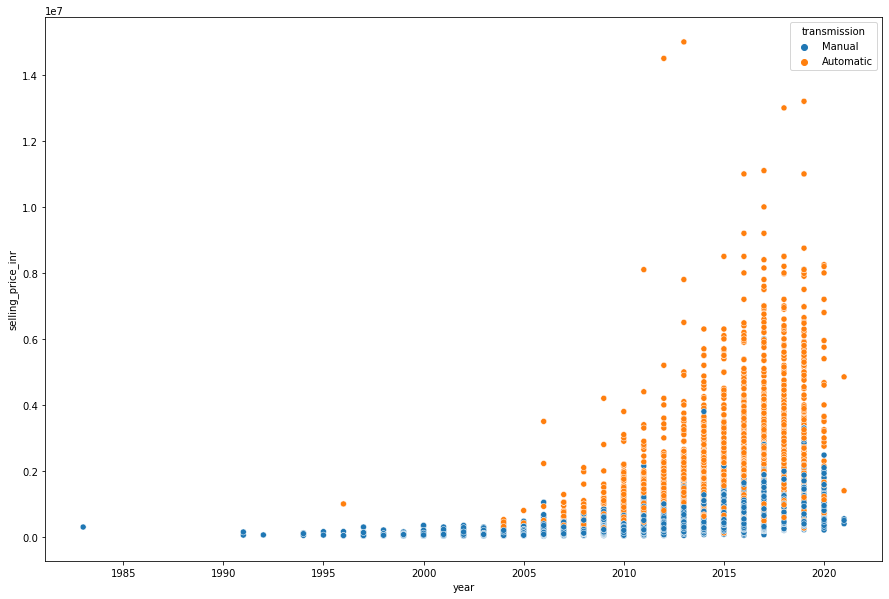

In [84]:
fig, scatter = plt.subplots(figsize = (15,10))
scatter = sns.scatterplot(data=clean_df, x="year", y="selling_price_inr", hue="transmission")

In general, the mean and deviation of car prices increase with each year and cars with automatic transmission tend to be more expensive.
## *km_driven* and *seller_type* features
The visualization below shows relation between *km_driven, seller_type* and *selling_price_inr* columns.

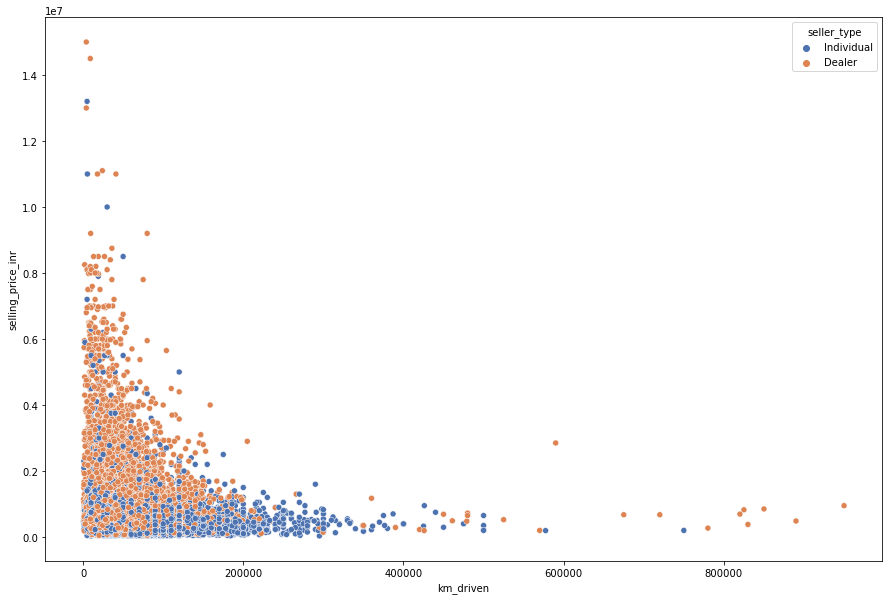

In [85]:
fig, scatter = plt.subplots(figsize = (15,10))
scatter = sns.scatterplot(data=clean_df, x="km_driven", y="selling_price_inr",hue="seller_type", palette="deep")

As can be seen, selling price tend to go down with the rise of *km_driven*. Also cars with 100000-600000 km driven are usually sold by individuals, but any clear pattern between *seller_type* and *selling_price_inr* columns is not observed.

## *engine_cc* and *max_power_bhp* features
The scatter plots below represent dependency between *engine_cc, max_power_bhp* and *selling_price_inr*.

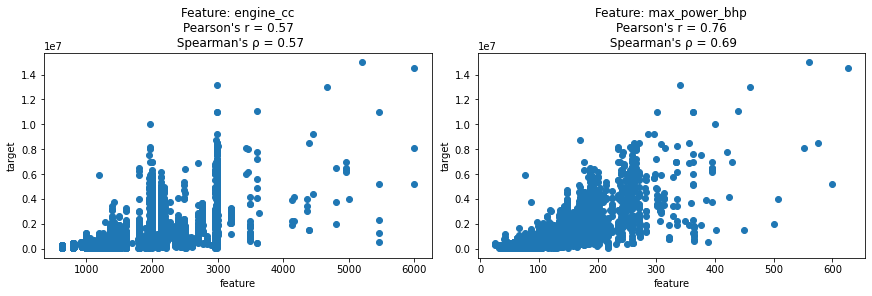

In [86]:
plot_col_signif(clean_df, ['engine_cc', 'max_power_bhp'], 'selling_price_inr', 1, 2)

As it is observed, both features have moderate-high correlation with selling price.

## *brand* feature
We'll visualize mean selling price grouped by *brand* values below.

In [87]:
def mean_per_col_barh(df, col):
    mean_price_per_col = df.groupby([col]).median()['selling_price_inr'].sort_values(ascending=False)

    fig, barplot = plt.subplots(figsize = (15,10))
    barplot = sns.barplot(x=mean_price_per_col.values, y=mean_price_per_col.index, orient='h', palette="viridis")
    barplot.bar_label(barplot.containers[0])
    barplot.spines['top'].set_visible(False)
    barplot.spines['right'].set_visible(False)
    barplot.spines['bottom'].set_visible(False)
    barplot.get_xaxis().set_ticks([])
    barplot.set_title(f'Mean car price for each {col}')
    barplot.set_ylabel('')
    plt.show()

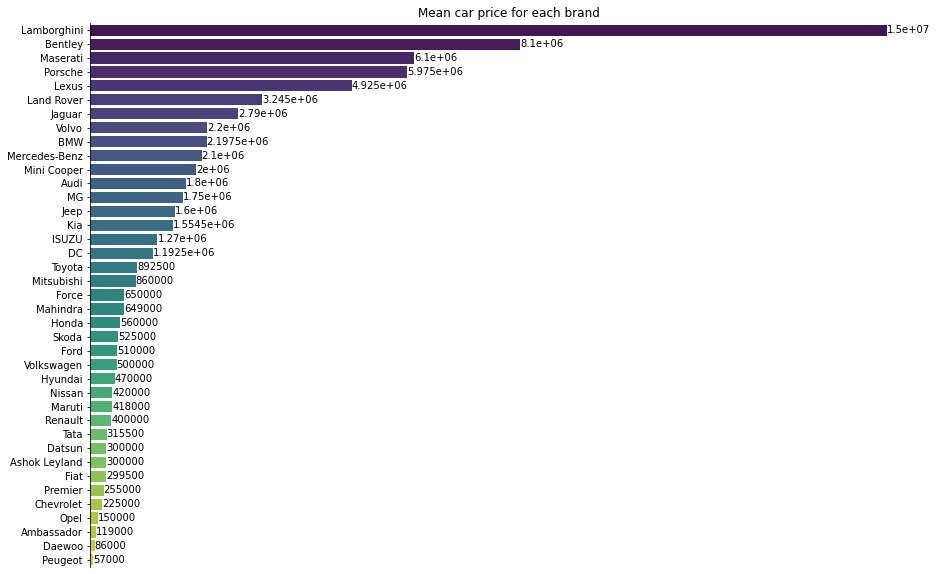

In [88]:
mean_per_col_barh(clean_df, 'brand')

Obviously, brand inluences the price and chart above confirms that it is true for our data.
## *seats, fuel, owner*  features
The boxplots below show distribituion of selling price values grouped by *seats, fuel* and *owner*.

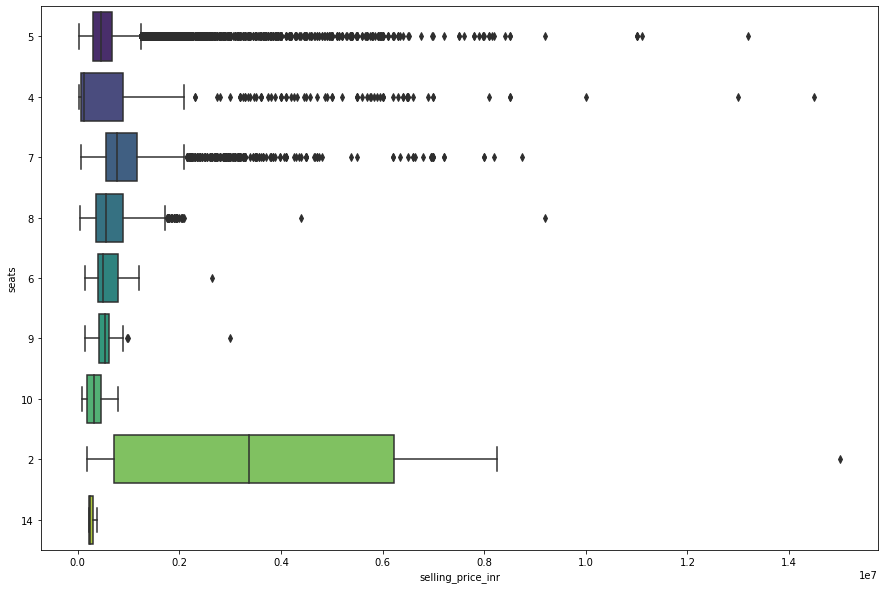

In [89]:
fig, boxplot = plt.subplots(figsize = (15,10))
boxplot = sns.boxplot(
    data=clean_df,
    x='selling_price_inr', 
    y='seats',
    orient='h',
    palette="viridis"
)

It can be clearly seen that selling price values of cars with 2, 4, 5 and 7 seats have big deviation, while other have price < 2,500,000 for most cases. 

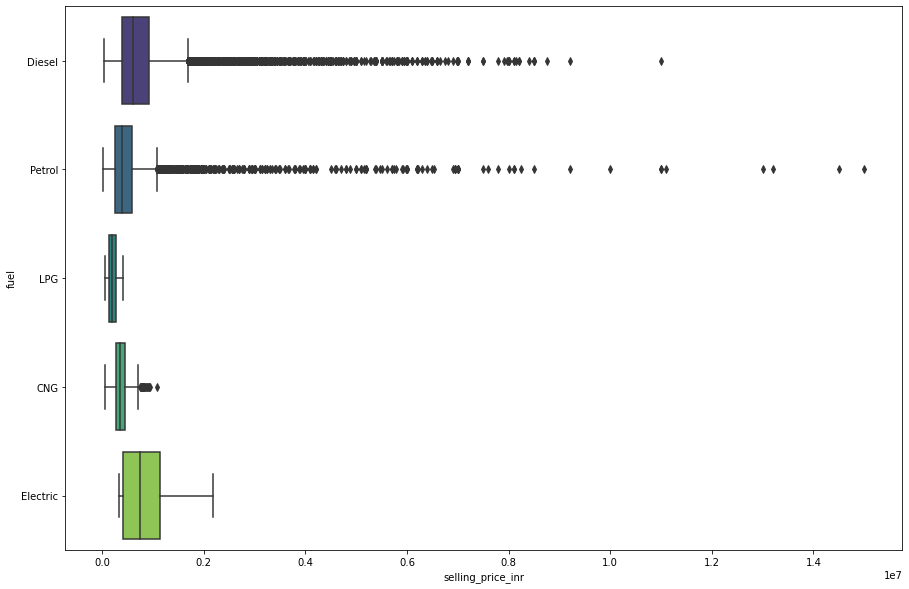

In [90]:
fig, boxplot = plt.subplots(figsize = (15,10))
boxplot = sns.boxplot(
    data=clean_df,
    x='selling_price_inr', 
    y='fuel',
    orient='h',
    palette="viridis"
)

The graph above reveals that selling prices of cars with petrol and diesel fuel also have big deviation, while other have price < 2,000,000. 

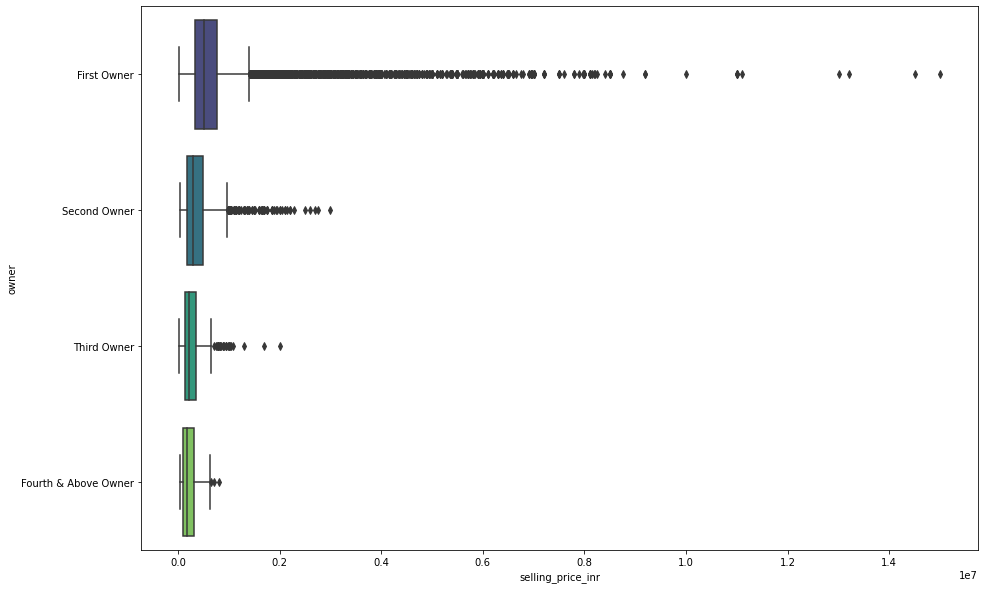

In [91]:
fig, boxplot = plt.subplots(figsize = (15,10))
boxplot = sns.boxplot(
    data=clean_df,
    x='selling_price_inr', 
    y='owner',
    orient='h',
    palette="viridis"
)

As was expected, the price of car tends to decrease with each owner. Also, there is a huge difference in deviation of selling price between first and second owner.

## Conclusion
As a result of exploratory data analysis, we find out that:
* selling price mean and deviation have positive correlation with **year** column;
* cars with automatic **transmission** tend to be more expensive;
* car price mean and deviation tend to go down with the rise of **km_driven** column;
* any clear pattern between **seller_type** and *selling_price_inr* columns is not observed;
* **engine_cc** has moderate correlation with selling price;
* **max_power_bhp** has high correlation with car price;
* prices of cars with 2, 4, 5 and 7 **seats** have big deviation, while other have price < 2,500,000 for most cases;
* selling prices of cars with petrol and diesel **fuel** also have big deviation, while other have price < 2,000,000;
* the price of car tends to decrease with each **owner** and there is a huge difference in deviation of selling price between first and second owner.

# Feature Engineering
Let's use knowledge we gained during exploratory analysis to create new features.

In [92]:
clean_df.head()

,name,year,selling_price_inr,km_driven,fuel,seller_type,transmission,owner,seats,engine_cc,max_power_bhp,brand
0,Maruti Swift Dzire VDI,2014.0,450000.0,145500.0,Diesel,Individual,Manual,First Owner,5,1248.0,74.00,Maruti
1,Skoda Rapid 1.5 TDI Ambition,2014.0,370000.0,120000.0,Diesel,Individual,Manual,Second Owner,5,1498.0,103.52,Skoda
2,Honda City 2017-2020 EXi,2006.0,158000.0,140000.0,Petrol,Individual,Manual,Third Owner,5,1497.0,78.00,Honda
3,Hyundai i20 Sportz Diesel,2010.0,225000.0,127000.0,Diesel,Individual,Manual,First Owner,5,1396.0,90.00,Hyundai
4,Maruti Swift VXI BSIII,2007.0,130000.0,120000.0,Petrol,Individual,Manual,First Owner,5,1298.0,88.20,Maruti


Selling prices of cars with petrol and diesel fuel have big deviation, while all other prices are lower than 2,000,000, so we will create new field *fuel_flg* = 1 if fuel is diesel or petrol and 0 in other cases. 